In [50]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from fred import Fred

## Step 1: Retrieve and manipulate the dataset from FRED

In [51]:
def observations(identifier, **kwargs):
    #using api from fred/series
    kwargs['series_id'] = identifier
    return Fred().series('observations', **kwargs)

os.environ['FRED_API_KEY'] = '76ac3067199f0ba3e30d851b81a16890'
data = []
for series in ['GS1','GS2','GS3','GS5','GS7','GS10']:
    df_request = observations(series)['observations']#get connection with API
    df = pd.DataFrame(df_request)[['date','value']]#retrieve values from API
    df = df.set_index('date')#set the index as date for data
    df.index = pd.to_datetime(df.index)
    data.append(df)
df = pd.concat(data, axis=1).loc[datetime(1976,6,1):,:].astype(np.float32)#check the time range for the combined dataset
df.columns = ['GS1','GS2','GS3','GS5','GS7','GS10']
df.head()
df.info()#check if there is null value

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 557 entries, 1976-06-01 to 2022-10-01
Freq: MS
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GS1     557 non-null    float32
 1   GS2     557 non-null    float32
 2   GS3     557 non-null    float32
 3   GS5     557 non-null    float32
 4   GS7     557 non-null    float32
 5   GS10    557 non-null    float32
dtypes: float32(6)
memory usage: 17.4 KB


In [52]:
df_return=df.pct_change().dropna()#check the monthly return of the data, and drop the null value of the dataset
df_return.head()

,GS1,GS2,GS3,GS5,GS7,GS10
date,,,,,,
1976-07-01,-0.049080,-0.029745,-0.025992,-0.015769,-0.006452,-0.003817
1976-08-01,-0.032258,-0.032117,-0.036517,-0.024032,-0.015584,-0.007663
1976-09-01,-0.026667,-0.031674,-0.029155,-0.024624,-0.022427,-0.023166
1976-10-01,-0.058219,-0.068536,-0.063063,-0.053296,-0.033738,-0.023715
1976-11-01,-0.038182,-0.028428,-0.024038,-0.034074,-0.041899,-0.016194


<AxesSubplot:xlabel='date'>

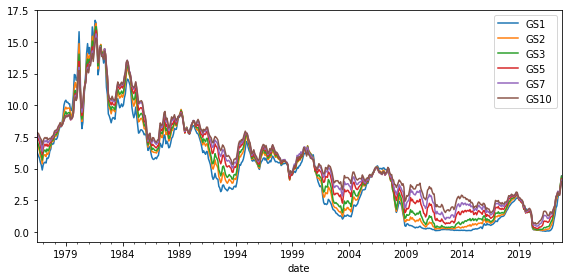

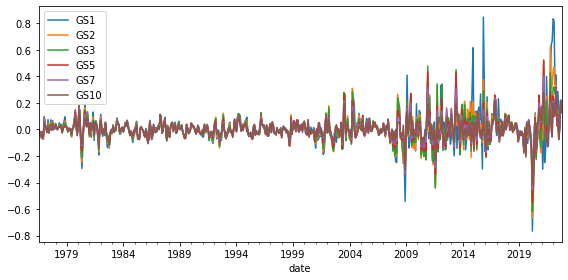

In [53]:
df.plot()#from the plot, there is seasonality and high correlation between each bond
df_return.plot()

## Step 2: Reduce dimension of the dataset using PCA

In [54]:
#normalize return data: (return-mean(return))/STD(return)
#r_norm = StandardScaler().fit_transform(df_return)
r_norm = (df_return - np.mean(df_return,axis=0))/np.std(df_return, axis=0)
r_norm.shape

(556, 6)

In [55]:
#check the auto solver of PCA first
pca1 = PCA(n_components = 'mle')
r_reduced = pca1.fit_transform(r_norm)
r_reduced.shape#we have 556 rows and 5-dimensional dataset
pca1.explained_variance_ratio_
# it seems like the last two dimension is not as significant, we can 
#reduce the dimension from 6 in original data to 3 to explain 99% of the 
#data

array([0.85743266, 0.1077819 , 0.02736547, 0.00539539, 0.00135039],
      dtype=float32)

In [56]:
pca2 = PCA(n_components = 3)
r_reduced2 = pca2.fit_transform(r_norm)
pca2.explained_variance_ratio_

array([0.85743314, 0.10778193, 0.02736552], dtype=float32)

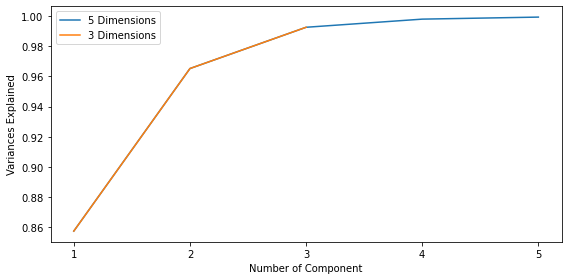

In [57]:
#Graph it out

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True
plt.plot(np.arange(1, len(pca1.explained_variance_ratio_)+1),np.cumsum(pca1.explained_variance_ratio_), label = '5 Dimensions')
plt.plot(np.arange(1, len(pca2.explained_variance_ratio_)+1),np.cumsum(pca2.explained_variance_ratio_), label = '3 Dimensions')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))#change x-axis to interger
plt.xlabel('Number of Component')
plt.ylabel('Variances Explained')
plt.legend()#add on labels for the graph

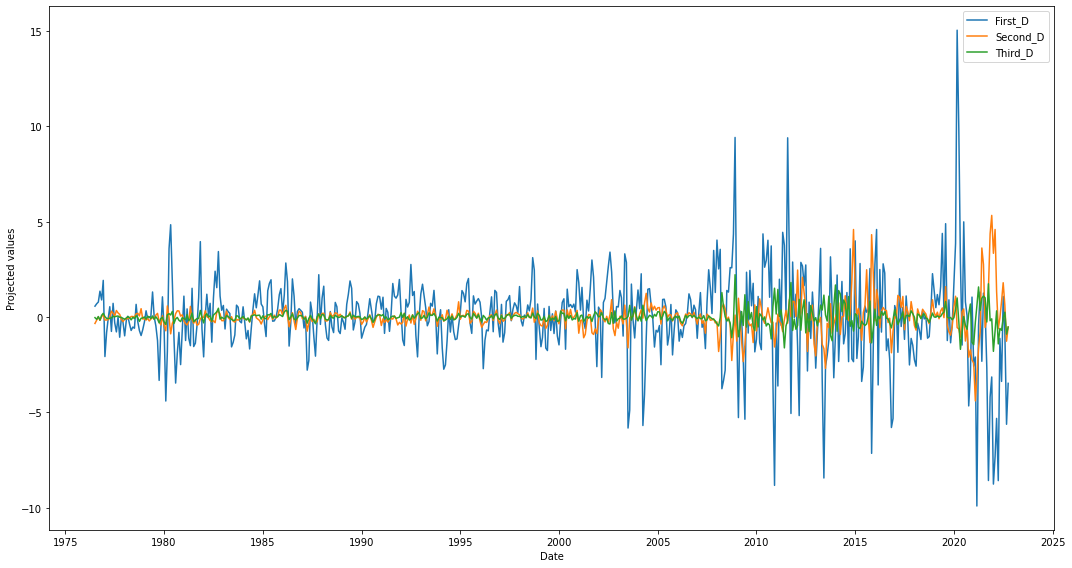

In [58]:
pca_data = pd.DataFrame(r_reduced2, columns = ['First_D','Second_D','Third_D'], index = r_norm.index)
x = r_norm.index.tolist()
fig = plt.figure(figsize=(15,8))
for col in pca_data.columns:
    plt.plot(x, pca_data[col],label=col)
plt.xlabel('Date')
plt.ylabel('Projected values')
plt.legend()

In [59]:
#In order to check if the stability of the model, we are using ADF hypothesis test to determine if the result is stationary
#H0: The time series is non-stationary.
#H1: The time series is stationary
for column in pca_data.columns:
    result = adfuller(pca_data.loc[:,column])
    print("%s ADF statistic Value: " % column, result[0])
    print("%s P-Value: " % column, result[1]) 
#From the result, it is clear that all p-value is less than 0.05, therefore, we are able to reject the null hypothesis that
#the time series PCA data is not stationary. In long term, our dimensional reduction is stationary, so it is stable. 


First_D ADF statistic Value:  -4.160084995135302
First_D P-Value:  0.00076925612248008
Second_D ADF statistic Value:  -6.036087879391541
Second_D P-Value:  1.3809966579496176e-07
Third_D ADF statistic Value:  -5.570061753284497
Third_D P-Value:  1.4743960439458105e-06
